# Voiced (유성음), Unvoiced (무성음), Silence (묵음)을 구분하는 분류기 생성
### 모든 모음은 유성음, 자음중 /s/, /f/, /th/, /ch/, /k/, /p/, /t/ 은 무성음

# Package 호출

In [2]:
import os
import sys
import numpy as np
import natsort
import glob
import random
import librosa
from distutils.dir_util import copy_tree
import re
import IPython # display wav files
import scipy.io.wavfile as wav
import scipy.signal as sps
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from gjdrawspectrogram3 import drawspectrogram3 # draw spectrogram
from gjfiroverlapadd import getLPHFIRFFT # linear phase FIR filter design from magnitudes of the frequency components
from gjfiroverlapadd import firoverlapadd # trapezoidal overlap add for FIR filtering
import gjwavfile as gwav # save audio in wav format
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

#### 필요한 값 정의

In [3]:
Fs = 16000
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의

cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
FIG_SIZE = (8,3)

In [4]:
def addpath(path, file):
    if len(path) == 0: 
        return file
    else:
        return path + '/' + file


def split_folder(src_folder, train_folder, val_folder, train_ratio=0.8, random_seed=42):
    # 폴더 내 파일 목록 가져오기
    files = os.listdir(src_folder)
    num_files = len(files)
    
    # 파일 목록을 랜덤하게 섞기
    random.seed(random_seed)
    random.shuffle(files)
    
    # train 및 validation 파일 개수 계산
    num_train = int(num_files * train_ratio)
    num_valid = num_files - num_train
    
    # train 파일 복사
    for i in range(num_train):
        file_name = files[i]
        src_path = addpath(src_folder, file_name)
        dst_path = addpath(train_folder, file_name)
        copy_tree(src_path, dst_path)
        
    # validation 파일 복사
    for i in range(num_train, num_files):
        file_name = files[i]
        src_path = addpath(src_folder, file_name)
        dst_path = addpath(val_folder, file_name)
        copy_tree(src_path, dst_path)
        
def split_wav(data, sample_rate, start, end):
    start *= sample_rate
    end *= sample_rate
    return data[start:end]

def DeleteAllFiles(filePath):
    if os.path.exists(filePath):
        for file in os.scandir(filePath):
            os.remove(file.path)
        os.rmdir(filePath)
        return 'Remove All File'
    else:
        return 'Directory Not Found'
    
def remove_files_in_directory(directory):
    file_list = os.listdir(directory)
    for file_name in file_list:
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)

# Train / Validation / Test
## 1. timit/train 데이터 8:2로 나누기 (Train:8, Validation: 2)
## 2. SA(dialect sentences)로 train / validation / test
## 3. SX(phonetically compact)로 train / validation / test

## 1. timit/train 데이터 8:2로 나누기 (Train:8, Validation: 2)

In [5]:
file_dir = 'timit_wav'
train_dir = addpath(file_dir,'train')            # 원래 train 파일 디렉토리
new_train_dir = addpath(file_dir, 'train_new')   # 분류한 train 파일 디렉토리
val_dir = addpath(file_dir, 'val')               # 분류한 validation 파일 디렉토리

if not os.path.exists(new_train_dir):
    os.makedirs(new_train_dir)
    
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

train_file_list = os.listdir(train_dir)
train_file_count = len(train_file_list)

for i in range(train_file_count):
    basename = 'dr%d'%(i+1)
    sub_train_dir = addpath(train_dir, basename)         # train 파일의 하위 디렉토리 dialect region ex: timit_wav/train/dr1
    newsub_train_dir = addpath(new_train_dir, basename)  # 분류 train 파일의 하위 디렉토리 ex: timit_wav/train_new/dr1
    sub_val_dir = addpath(val_dir, basename)             # validation 파일의 하위 디렉토리
    if not os.path.exists(newsub_train_dir):
        os.makedirs(newsub_train_dir)
    if not os.path.exists(sub_val_dir):
        os.makedirs(sub_val_dir)
        
    split_folder(sub_train_dir, newsub_train_dir, sub_val_dir, train_ratio=0.8, random_seed=42)

## 2. SA(dialect sentences)로 train / validation / test
### 2-1. EPD or VAD 를 이용하여 1차 구분
### 2-2. autocorrelation 을 이용하여 voiced/unvoiced rough 구분
### 2-3. ZCR, median filter, heuristic 적용
### 2-4. RNN

#### 관련 함수

In [118]:
# EPD 음성구간 확장 함수 ---------------------------------------------------------------------------------------
def add_silence_to_wav(data, sample_rate, silence_duration_start, silence_duration_end):
    # 무음을 위한 샘플 개수 계산
    num_samples_start = int(silence_duration_start * sample_rate)
    num_samples_end = int(silence_duration_end * sample_rate)

    # 무음 샘플 생성
    if data.ndim == 1:
        # 단일 채널 WAV 파일인 경우
        silence_start = np.zeros(num_samples_start, dtype=data.dtype)
        silence_end = np.zeros(num_samples_end, dtype=data.dtype)
    else:
        # 다중 채널 WAV 파일인 경우
        num_channels = data.shape[1]
        silence_start = np.zeros((num_samples_start, num_channels), dtype=data.dtype)
        silence_end = np.zeros((num_samples_end, num_channels), dtype=data.dtype)

    # 무음을 WAV 데이터 앞뒤에 추가
    data_with_silence = np.concatenate((silence_start, data, silence_end))

    return data_with_silence


def epd(wrd_file, phn_file, wav_dir, cnt):
    
    silence_duration_start = 0.5  # 앞에 추가할 무음의 지속 시간 (초)
    silence_duration_end = 0.5  # 뒤에 추가할 무음의 지속 시간 (초)

    wrd_file = open(wrd_file, 'r')
    phn_file = open(phn_file, 'r')
    wrd_data = wrd_file.readlines()
    phn_data = phn_file.readlines()

    sr, y = wav.read(addpath(wav_dir, 'sa{}.wav'.format(p+1)))

    # .wrd 파일에 대하여 EPD 음성 확장
    for q in range(len(wrd_data)):
        wrd_num_line = re.findall("\d+", wrd_data[q])  # print(wrd_num_line)
        wrd_str_line = re.findall(r'[^\d\s]+', wrd_data[q]) # print(wrd_str_line) #print(num_line[0], num_line[1]) #print(str_line[0])
        output_wrd_wav_file = addpath(addpath(wav_dir, 'sa_words'), 'sa{}_{}_{}.wav'.format(cnt+1,q+1,wrd_str_line[0]))  
        wrd_y_seg = y[int(wrd_num_line[0]):int(wrd_num_line[1])]

        # 무음 추가
        wrd_data_with_silence = add_silence_to_wav(wrd_y_seg, sr, silence_duration_start, silence_duration_end)

        wav.write(output_wrd_wav_file, sr, wrd_data_with_silence)

     # .phn 파일에 대하여 EPD 음성 확장
    for r in range(len(phn_data)):
        phn_num_line = re.findall("\d+", phn_data[r])  # print(phn_num_line)
        phn_str_line = re.findall(r'[^\d\s]+', phn_data[r]) # print(phn_str_line) #print(phn_num_line[0], phn_num_line[1]) #print(phn_str_line[0])
        output_phn_wav_file = addpath(addpath(wav_dir, 'sa_sounds'), 'sa{}_{}_{}.wav'.format(cnt+1,r+1,phn_str_line[0]))  
        phn_y_seg = y[int(phn_num_line[0]):int(phn_num_line[1])]

        # 무음 추가
        phn_data_with_silence = add_silence_to_wav(phn_y_seg, sr, silence_duration_start, silence_duration_end)

        wav.write(output_phn_wav_file, sr, phn_data_with_silence)

    wrd_file.close()
    phn_file.close()
        


# Autocorrelation을 통한 voiced/unvoiced 구분 함수 ------------------------------------------------------------
def classify_voiced_unvoiced(audio, fs):
    # Autocorrelation 계산
    autocorr = np.correlate(audio, audio, mode='full')
    autocorr = autocorr[len(autocorr) // 2:]

    # 첫 번째와 두 번째 peak 간의 비율을 계산하여 voiced/unvoiced 판단
    ratio = autocorr[1] / autocorr[0] #print("ratio", ratio)

    # Threshold 값 설정
    voiced_threshold = 0.72
    unvoiced_threshold = 0.2

    if ratio > voiced_threshold:
        return 'Voiced'
    elif ratio < unvoiced_threshold:
        return 'Unvoiced'
    else:
        return 'Silence'

    # Threshold 값 설정
#     voiced_threshold = 0.5

#     if ratio > voiced_threshold:
#         return 'voiced'
#     else:
#         return 'unvoiced'



# ZCR(Zero-Crossing Rate), Median Filter, Heuristic 적용 함수 ----------------------------------------------------------------------------
def classify_voiced_unvoiced_silence(audio, fs):
    # ZCR 계산
    zcr = librosa.feature.zero_crossing_rate(audio, frame_length=len(audio), hop_length=1)
    zcr = np.squeeze(zcr)

    # Median filter 적용
    median_filtered = sps.medfilt(zcr, kernel_size=3)
    
    
    # Heuristic 기반 분류
    voiced_threshold = 0.009817981246552676642684 # 0.02 #0.009817981246552676642684
    #voiced_threshold = np.mean(median_filtered) + np.std(median_filtered)
    unvoiced_threshold = 0.03  #0.07

    classification = []
    for z in median_filtered:
        if z < voiced_threshold:
            classification.append('voiced')
        elif z > unvoiced_threshold:
            classification.append('unvoiced')
        else:
            classification.append('silence')
            
    return classification

# 휴리스틱 기반 voiced/unvoiced/silence 분류
def classify_heuristic(autocorr, zcr):
    threshold_voiced = 0.2
    threshold_unvoiced = 0.1
    
    classification = []
    
    # autocorr, zcr을 배열로 변환
    autocorr = np.atleast_1d(autocorr)
    zcr = np.atleast_1d(zcr)
    
    # 배열 요소별 분류 수행
    for ac, zc in zip(autocorr, zcr):
        if ac > threshold_voiced and zc < threshold_unvoiced:
            classification.append("voiced")
        elif ac < threshold_unvoiced:
            classification.append("unvoiced")
        else:
            classification.append("silence")
    
    return classification

                   
# RNN 함수 ------------------------------------------------------------------------------------------------------------
# 음성 데이터를 로드하고 전처리하는 함수
def load_data(file_path):
    # WAV 파일 로드
    sample_rate, data = wav.read(file_path)
    
    # ZCR 계산
    zcr = np.sum(np.abs(np.diff(np.sign(data)))) / len(data)
    
    # Median Filter 적용
    data = medfilt(data, kernel_size=3)
    
    # 데이터 전처리 (예: 정규화, 스케일 조정)
    data = data.astype(np.float32)
    data /= np.max(np.abs(data))
    
    return data

# 데이터를 입력과 타겟 시퀀스로 변환하는 함수
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    data_length = len(data)
    
    for i in range(0, data_length - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])
        
    return np.array(sequences), np.array(targets)

# 데이터 레이블을 생성하는 함수
def create_labels(data, threshold):
    labels = []
    
    for values in data:
        label = []
        for value in values:
            if abs(value) > threshold:  # voiced(음성)인 경우
                label.append([0])
            elif abs(value) <= threshold:  # unvoiced(무음) 또는 silence(정지)인 경우
                label.append([1])
        labels.append(label)
            
    return np.array(labels)



# 음성 데이터 분류
def classify_audio(audio):
    # RNN 모델 생성
    model = create_rnn_model(input_dim, hidden_units, output_classes)
        
    initial_classification = classify_voiced_unvoiced(audio, sr)
    final_classification = classify_voiced_unvoiced_silence(audio, sr)
    
    #audio_rnn, sr_rnn = preprocess_audio(audio)
        
    # 특성 추출
    features = extract_features(audio)

    # 모델에 입력 데이터 제공하여 분류 수행
    rnn_input = np.expand_dims(features, axis=0)
    classification = model.predict(rnn_input)
    predicted_class = np.argmax(classification)
    
    # 분류 결과를 voiced, unvoiced, silence로 변환
    if predicted_class == 0:
        predicted_label = "voiced"
    elif predicted_class == 1:
        predicted_label = "unvoiced"
    else:
        predicted_label = "silence"
    

    return initial_classification, final_classification, predicted_label


#### 2-1. EPD or VAD 를 이용하여 1차 구분

train data EPD

In [7]:
new_train_list = os.listdir(new_train_dir)  # ['dr1', 'dr2', 'dr3', 'dr4', 'dr5', 'dr6', 'dr7', 'dr8']

for i in new_train_list:
    sub_train_dir = addpath(new_train_dir, i)  # timit_wav/train_new/dr*
    new_sub_train_list = os.listdir(sub_train_dir) # dr의 하위 디렉토리
    new_sub_train_list = natsort.natsorted(new_sub_train_list) # 제대로 불러왔는지 확인하기 위해 sort
    
    # SA wav file 경로 호출
    for j in new_sub_train_list:
        wav_dir = addpath(sub_train_dir, j) # timit_wav/train_new/dr1/fcjf0
        sa_wav_file = glob.glob(f"{wav_dir}/sa*.wav")
        sa_wrd_file = glob.glob(f"{wav_dir}/sa*.wrd")
        sa_phn_file = glob.glob(f"{wav_dir}/sa*.phn")
            
        if not os.path.exists(addpath(wav_dir, 'sa_words')):# dr의 하위 디렉토리에 대해 sa_words 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sa_words'))
        if not os.path.exists(addpath(wav_dir, 'sa_sounds')): # dr의 하위 디렉토리에 대해 sa_sounds 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sa_sounds'))
        
        for p in range(len(sa_wrd_file)):
            epd(sa_wrd_file[p], sa_phn_file[p], wav_dir, p)

        #remove_files_in_directory(wav_dir)

validation data EPD

In [8]:
val_list = os.listdir(val_dir) # ['dr1', 'dr2', 'dr3', 'dr4', 'dr5', 'dr6', 'dr7', 'dr8']

for i in val_list:
    sub_val_dir = addpath(val_dir, i)
    sub_val_list = os.listdir(sub_val_dir)
    sub_val_list = natsort.natsorted(sub_val_list)
    
    # SA wav file 경로 호출
    for j in sub_val_list:
        wav_dir = addpath(sub_val_dir, j) # timit_wav/train_new/dr1/fcjf0
        sa_wav_file = glob.glob(f"{wav_dir}/sa*.wav")
        sa_wrd_file = glob.glob(f"{wav_dir}/sa*.wrd")
        sa_phn_file = glob.glob(f"{wav_dir}/sa*.phn")
            
        if not os.path.exists(addpath(wav_dir, 'sa_words')):# dr의 하위 디렉토리에 대해 sa_words 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sa_words'))
        if not os.path.exists(addpath(wav_dir, 'sa_sounds')): # dr의 하위 디렉토리에 대해 sa_sounds 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sa_sounds'))
        
        for p in range(len(sa_wrd_file)):
            epd(sa_wrd_file[p], sa_phn_file[p], wav_dir, p)

array([[-100., -100., -100., ..., -100., -100., -100.],
       [-100., -100., -100., ..., -100., -100., -100.],
       [-100., -100., -100., ..., -100., -100., -100.],
       ...,
       [-100., -100., -100., ..., -100., -100., -100.],
       [-100., -100., -100., ..., -100., -100., -100.],
       [-100., -100., -100., ..., -100., -100., -100.]])

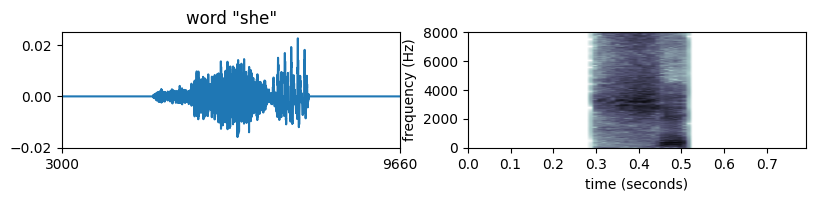

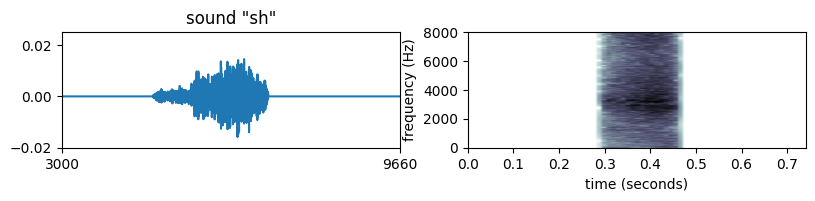

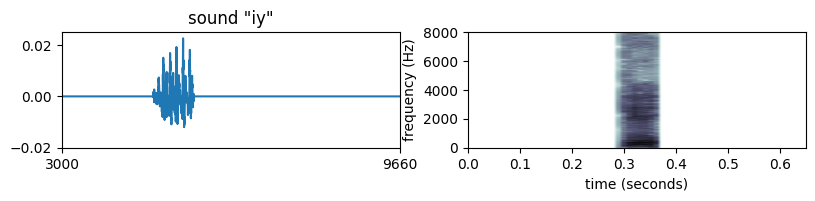

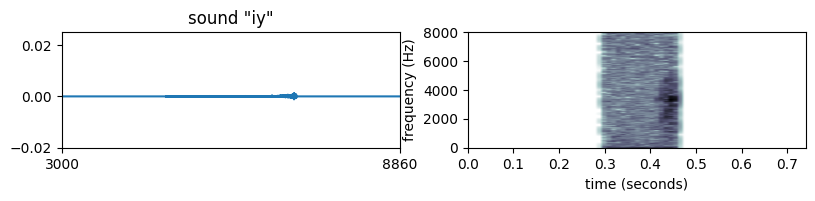

In [60]:
# autocorrelation 전 original signal plot
file = addpath(wav_dir, 'sa_sounds/sa1_1_h#.wav')
word_wav_file = addpath(wav_dir, 'sa_words/sa1_1_she.wav')
phoneme_wav_file_1 = addpath(wav_dir, 'sa_sounds/sa1_2_sh.wav')
phoneme_wav_file_2 = addpath(wav_dir, 'sa_sounds/sa1_3_iy.wav')
speech, Fs = librosa.load(file, sr=None, mono=True)
speech1, Fs1 = librosa.load(word_wav_file, sr=None, mono=True)
speech2, Fs2 = librosa.load(phoneme_wav_file_1, sr=None, mono=True)
speech3, Fs3 = librosa.load(phoneme_wav_file_2, sr=None, mono=True)

plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
plt.subplot(1,2,1)
plt.plot(speech1); plt.xlim(0+silence_duration_start*10000,len(speech1)-silence_duration_end*10000); plt.ylim(-0.02,0.025); plt.xticks([0+silence_duration_start*10000, len(speech1)-silence_duration_end*10000])
plt.title('word "she"')
plt.subplot(1,2,2)
drawspectrogram3(speech1, Fs1, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)

plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
plt.subplot(1,2,1)
plt.plot(speech2); plt.xlim(0+silence_duration_start*10000,len(speech1)-silence_duration_end*10000); plt.ylim(-0.02,0.025); plt.xticks([0+silence_duration_start*10000, len(speech1)-silence_duration_end*10000])
plt.title('sound "sh"')
plt.subplot(1,2,2)
drawspectrogram3(speech2, Fs2, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)

plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
plt.subplot(1,2,1)
plt.plot(speech3); plt.xlim(0+silence_duration_start*10000,len(speech1)-silence_duration_end*10000); plt.ylim(-0.02,0.025); plt.xticks([0+silence_duration_start*10000, len(speech1)-silence_duration_end*10000])
plt.title('sound "iy"')
plt.subplot(1,2,2)
drawspectrogram3(speech3, Fs3, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)

plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
plt.subplot(1,2,1)
plt.plot(speech); plt.xlim(0+silence_duration_start*10000,len(speech)-silence_duration_end*10000); plt.ylim(-0.02,0.025); plt.xticks([0+silence_duration_start*10000, len(speech)-silence_duration_end*10000])
plt.title('sound "iy"')
plt.subplot(1,2,2)
drawspectrogram3(speech, Fs, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)


train & validation data

In [95]:
train_files = []
for i in new_train_list:
    sub_train_dir = addpath(new_train_dir, i)  # timit_wav/train_new/dr*
    ssub_train_list = os.listdir(sub_train_dir)
    ssub_train_list = natsort.natsorted(ssub_train_list) 
    
    # .phn 파일 호출
    for j in ssub_train_list:
        sa_sounds_train_dir = addpath(addpath(sub_train_dir, j), 'sa_sounds') # timit_wav/train_new/dr*/*/sa_sounds
        train_file = glob.glob(addpath(sa_sounds_train_dir, '*.wav'))
        train_files.extend(train_file)

val_files = []
for i in val_list:
    sub_val_dir = addpath(val_dir, i)
    sub_val_list = os.listdir(sub_val_dir)
    sub_val_list = natsort.natsorted(sub_val_list)
    
    # .phn 파일 호출
    for j in sub_val_list:
        sa_sounds_val_dir = addpath(addpath(sub_val_dir, j), 'sa_sounds') # timit_wav/train_new/dr*/*/sa_sounds
        val_file = glob.glob(addpath(sa_sounds_val_dir, '*.wav'))
        val_files.extend(val_file)

In [105]:
# 훈련 데이터 로드
train_data = []
for path in train_files:
    train_data.append(load_data(path))

# validation 데이터 로드
val_data = []
for path in val_files:
    val_data.append(load_data(path))

In [ ]:
# 데이터 전처리 및 시퀀스 생성
sequence_length = 100  # 입력 시퀀스 길이
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)

# 데이터 레이블 생성
threshold = 0.1  # 음성과 무음/정지를 구분하는 임계값
y_train_labels = create_labels(y_train, threshold)
y_val_labels = create_labels(y_val, threshold)

# RNN 모델 생성
model = Sequential()
model.add(SimpleRNN(64, input_shape=(sequence_length, 1)))
model.add(Dense(1))

# 모델 컴파일 및 훈련
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_labels, validation_data=(X_val, y_val_labels), epochs=10, batch_size=64)

test data

In [113]:
test_dir = addpath(file_dir,'test')
test_dr_list = os.listdir(test_dir)

for i in test_dr_list:
    sub_test_dir = addpath(test_dir, i)
    sub_test_list = os.listdir(sub_test_dir)
    sub_test_list = natsort.natsorted(sub_test_list)
    
    # SA wav file 경로 호출
    for j in sub_test_list:
        wav_dir = addpath(sub_test_dir, j) # timit_wav/train_new/dr1/fcjf0
        sa_wav_file = glob.glob(f"{wav_dir}/sa*.wav")
        sa_wrd_file = glob.glob(f"{wav_dir}/sa*.wrd")
        sa_phn_file = glob.glob(f"{wav_dir}/sa*.phn")
            
        if not os.path.exists(addpath(wav_dir, 'sa_words')):# dr의 하위 디렉토리에 대해 sa_words 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sa_words'))
        if not os.path.exists(addpath(wav_dir, 'sa_sounds')): # dr의 하위 디렉토리에 대해 sa_sounds 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sa_sounds'))
        
        for p in range(len(sa_wrd_file)):
            epd(sa_wrd_file[p], sa_phn_file[p], wav_dir, p)

In [126]:
test_files = []
for i in test_dr_list:
    sub_test_dir = addpath(test_dir, i)
    sub_test_list = os.listdir(sub_test_dir)
    sub_test_list = natsort.natsorted(sub_test_list)
    
    # .phn 파일 호출
    for j in sub_test_list:
        sa_sounds_test_dir = addpath(addpath(sub_test_dir, j), 'sa_words') # timit_wav/train_new/dr*/*/sa_sounds
        test_file = glob.glob(addpath(sa_sounds_test_dir, '*.wav'))
        test_files.extend(test_file)

In [ ]:
test_files = []
for i in test_dr_list:
    sub_test_dir = addpath(test_dir, i)
    sub_test_list = os.listdir(sub_test_dir)
    sub_test_list = natsort.natsorted(sub_test_list)
    
    # .phn 파일 호출
    for j in sub_test_list:
        sa_sounds_test_dir = addpath(addpath(sub_test_dir, j), 'sa_words') # timit_wav/train_new/dr*/*/sa_sounds
        test_file = glob.glob(addpath(sa_sounds_test_dir, '*.wav'))
        
        for p in test_file:
            #sound_sr, sound_sig = wav.read(p)
            sound_sig, sound_sr = librosa.load(p, sr=None)
            initial_class = classify_voiced_unvoiced(sound_sig, sound_sr)
            
            print(p, ": ", initial_class)

In [139]:
# test
test_data = []
for path in test_files:
    # 데이터 전처리 및 시퀀스 생성
    X_test, y_test = create_sequences(test_data, sequence_length)

    # 예측
    predictions = model.predict(X_test)


    # 예측 결과 출력 또는 활용
    result = []
    for prediction in predictions:
        if prediction < 0.5:  # unvoiced(무음) 또는 silence(정지)
            result.append("voiced")
        elif prediction > 0.5:  # voiced(음성)
            result.append("unvoiced")
        else:
            result.append("silence")

    result = max(set(result), key=result.count)
#     print(p, ":", initial_class,"->", result)
    print(p, ":", result)
    print("-------------------------------------")
    #test_data.append(load_data(path))

#### 2-2. autocorrelation을 이용하여 voiced/unvoiced rough 구분 / 2-3. ZCR, median filter, heuristic 적용 / 2-4. RNN

## 3. SX(phonetically compact)로 train / validation / test

### EPD or VAD 를 이용하여 1차 구분

train data EPD

In [122]:
new_train_list = os.listdir(new_train_dir)  # ['dr1', 'dr2', 'dr3', 'dr4', 'dr5', 'dr6', 'dr7', 'dr8']

for i in new_train_list:
    sub_train_dir = addpath(new_train_dir, i)  # timit_wav/train_new/dr*
    new_sub_train_list = os.listdir(sub_train_dir) # dr의 하위 디렉토리
    new_sub_train_list = natsort.natsorted(new_sub_train_list) # 제대로 불러왔는지 확인하기 위해 sort
    
    # SA wav file 경로 호출
    for j in new_sub_train_list:
        wav_dir = addpath(sub_train_dir, j) # timit_wav/train_new/dr1/fcjf0
        sx_wav_file = glob.glob(f"{wav_dir}/sx*.wav") #print(sa_wav_file, sx_wav_file)
        sx_wrd_file = glob.glob(f"{wav_dir}/sx*.wrd")
        sx_phn_file = glob.glob(f"{wav_dir}/sx*.phn")
            
        if not os.path.exists(addpath(wav_dir, 'sx_words')):# dr의 하위 디렉토리에 대해 sa_words 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sx_words'))
        if not os.path.exists(addpath(wav_dir, 'sx_sounds')): # dr의 하위 디렉토리에 대해 sa_sounds 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sx_sounds'))
        
        for p in range(len(sx_wrd_file)):
            epd(sx_wrd_file[p], sx_phn_file[p], wav_dir, p)

        #remove_files_in_directory(wav_dir)

timit_wav/train_new/dr1/fcjf0\sa1.wrd
timit_wav/train_new/dr1/fcjf0\sa2.wrd
timit_wav/train_new/dr1/fdml0\sa1.wrd
timit_wav/train_new/dr1/fdml0\sa2.wrd
timit_wav/train_new/dr1/fecd0\sa1.wrd
timit_wav/train_new/dr1/fecd0\sa2.wrd
timit_wav/train_new/dr1/fetb0\sa1.wrd
timit_wav/train_new/dr1/fetb0\sa2.wrd
timit_wav/train_new/dr1/fjsp0\sa1.wrd
timit_wav/train_new/dr1/fjsp0\sa2.wrd
timit_wav/train_new/dr1/fsjk1\sa1.wrd
timit_wav/train_new/dr1/fsjk1\sa2.wrd
timit_wav/train_new/dr1/fsma0\sa1.wrd
timit_wav/train_new/dr1/fsma0\sa2.wrd
timit_wav/train_new/dr1/ftbr0\sa1.wrd
timit_wav/train_new/dr1/ftbr0\sa2.wrd
timit_wav/train_new/dr1/fvfb0\sa1.wrd
timit_wav/train_new/dr1/fvfb0\sa2.wrd
timit_wav/train_new/dr1/fvmh0\sa1.wrd
timit_wav/train_new/dr1/fvmh0\sa2.wrd
timit_wav/train_new/dr1/mdpk0\sa1.wrd
timit_wav/train_new/dr1/mdpk0\sa2.wrd
timit_wav/train_new/dr1/mgrl0\sa1.wrd
timit_wav/train_new/dr1/mgrl0\sa2.wrd
timit_wav/train_new/dr1/mjeb1\sa1.wrd
timit_wav/train_new/dr1/mjeb1\sa2.wrd
timit_wav/tr

timit_wav/train_new/dr7/fksr0\sa1.wrd
timit_wav/train_new/dr7/fksr0\sa2.wrd
timit_wav/train_new/dr7/fleh0\sa1.wrd
timit_wav/train_new/dr7/fleh0\sa2.wrd
timit_wav/train_new/dr7/flet0\sa1.wrd
timit_wav/train_new/dr7/flet0\sa2.wrd
timit_wav/train_new/dr7/fmkc0\sa1.wrd
timit_wav/train_new/dr7/fmkc0\sa2.wrd
timit_wav/train_new/dr7/freh0\sa1.wrd
timit_wav/train_new/dr7/freh0\sa2.wrd
timit_wav/train_new/dr7/fspm0\sa1.wrd
timit_wav/train_new/dr7/fspm0\sa2.wrd
timit_wav/train_new/dr7/madd0\sa1.wrd
timit_wav/train_new/dr7/madd0\sa2.wrd
timit_wav/train_new/dr7/maeo0\sa1.wrd
timit_wav/train_new/dr7/maeo0\sa2.wrd
timit_wav/train_new/dr7/mafm0\sa1.wrd
timit_wav/train_new/dr7/mafm0\sa2.wrd
timit_wav/train_new/dr7/mbar0\sa1.wrd
timit_wav/train_new/dr7/mbar0\sa2.wrd
timit_wav/train_new/dr7/mbbr0\sa1.wrd
timit_wav/train_new/dr7/mbbr0\sa2.wrd
timit_wav/train_new/dr7/mbml0\sa1.wrd
timit_wav/train_new/dr7/mbml0\sa2.wrd
timit_wav/train_new/dr7/mbom0\sa1.wrd
timit_wav/train_new/dr7/mbom0\sa2.wrd
timit_wav/tr

validation data EPD

In [8]:
val_list = os.listdir(val_dir) # ['dr1', 'dr2', 'dr3', 'dr4', 'dr5', 'dr6', 'dr7', 'dr8']

for i in val_list:
    sub_val_dir = addpath(val_dir, i)
    sub_val_list = os.listdir(sub_val_dir)
    sub_val_list = natsort.natsorted(sub_val_list)
    
    # SA wav file 경로 호출
    for j in sub_val_list:
        wav_dir = addpath(sub_val_dir, j) # timit_wav/train_new/dr1/fcjf0
        sx_wav_file = glob.glob(f"{wav_dir}/sx*.wav")
        sx_wrd_file = glob.glob(f"{wav_dir}/sx*.wrd")
        sx_phn_file = glob.glob(f"{wav_dir}/sx*.phn")
            
        if not os.path.exists(addpath(wav_dir, 'sx_words')):# dr의 하위 디렉토리에 대해 sa_words 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sx_words'))
        if not os.path.exists(addpath(wav_dir, 'sx_sounds')): # dr의 하위 디렉토리에 대해 sa_sounds 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sx_sounds'))
        
        for p in range(len(sx_wrd_file)):
            epd(sx_wrd_file[p], sx_phn_file[p], wav_dir, p)

train & validation data

In [95]:
train_files = []
for i in new_train_list:
    sub_train_dir = addpath(new_train_dir, i)  # timit_wav/train_new/dr*
    ssub_train_list = os.listdir(sub_train_dir)
    ssub_train_list = natsort.natsorted(ssub_train_list) 
    
    # .phn 파일 호출
    for j in ssub_train_list:
        sx_sounds_train_dir = addpath(addpath(sub_train_dir, j), 'sx_sounds') # timit_wav/train_new/dr*/*/sa_sounds
        train_file = glob.glob(addpath(sx_sounds_train_dir, '*.wav'))
        train_files.extend(train_file)

val_files = []
for i in val_list:
    sub_val_dir = addpath(val_dir, i)
    sub_val_list = os.listdir(sub_val_dir)
    sub_val_list = natsort.natsorted(sub_val_list)
    
    # .phn 파일 호출
    for j in sub_val_list:
        sx_sounds_val_dir = addpath(addpath(sub_val_dir, j), 'sx_sounds') # timit_wav/train_new/dr*/*/sa_sounds
        val_file = glob.glob(addpath(sx_sounds_val_dir, '*.wav'))
        val_files.extend(val_file)

In [105]:
# 훈련 데이터 로드
train_data = []
for path in train_files:
    train_data.append(load_data(path))

# validation 데이터 로드
val_data = []
for path in val_files:
    val_data.append(load_data(path))

In [ ]:
# 데이터 전처리 및 시퀀스 생성
sequence_length = 100  # 입력 시퀀스 길이
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)

# 데이터 레이블 생성
threshold = 0.1  # 음성과 무음/정지를 구분하는 임계값
y_train_labels = create_labels(y_train, threshold)
y_val_labels = create_labels(y_val, threshold)

# RNN 모델 생성
model = Sequential()
model.add(SimpleRNN(64, input_shape=(sequence_length, 1)))
model.add(Dense(1))

# 모델 컴파일 및 훈련
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_labels, validation_data=(X_val, y_val_labels), epochs=10, batch_size=64)

/var/folders/nc/tq6g2g_j5kz9j4crt1fm3c9m0000gn/T/ipykernel_8824/2761541513.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences), np.array(targets)


test data

In [113]:
test_dir = addpath(file_dir,'test')
test_dr_list = os.listdir(test_dir)

for i in test_dr_list:
    sub_test_dir = addpath(test_dir, i)
    sub_test_list = os.listdir(sub_test_dir)
    sub_test_list = natsort.natsorted(sub_test_list)
    
    # SA wav file 경로 호출
    for j in sub_test_list:
        wav_dir = addpath(sub_test_dir, j) # timit_wav/train_new/dr1/fcjf0
        sx_wav_file = glob.glob(f"{wav_dir}/sx*.wav")
        sx_wrd_file = glob.glob(f"{wav_dir}/sx*.wrd")
        sx_phn_file = glob.glob(f"{wav_dir}/sx*.phn")
            
        if not os.path.exists(addpath(wav_dir, 'sx_words')):# dr의 하위 디렉토리에 대해 sa_words 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sx_words'))
        if not os.path.exists(addpath(wav_dir, 'sx_sounds')): # dr의 하위 디렉토리에 대해 sa_sounds 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sx_sounds'))
        
        for p in range(len(sx_wrd_file)):
            epd(sx_wrd_file[p], sx_phn_file[p], wav_dir, p)

In [114]:
test_files = []
for i in test_dr_list:
    sub_test_dir = addpath(test_dir, i)
    sub_test_list = os.listdir(sub_test_dir)
    sub_test_list = natsort.natsorted(sub_test_list)
    
    # .phn 파일 호출
    for j in sub_test_list:
        sx_sounds_test_dir = addpath(addpath(sub_test_dir, j), 'sx_words') # timit_wav/train_new/dr*/*/sa_sounds
        test_file = glob.glob(addpath(sx_sounds_test_dir, '*.wav'))
        test_files.extend(test_file)

In [ ]:
test_files = []
for i in test_dr_list:
    sub_test_dir = addpath(test_dir, i)
    sub_test_list = os.listdir(sub_test_dir)
    sub_test_list = natsort.natsorted(sub_test_list)
    
    # .phn 파일 호출
    for j in sub_test_list:
        sa_sounds_test_dir = addpath(addpath(sub_test_dir, j), 'sx_words') # timit_wav/train_new/dr*/*/sa_sounds
        test_file = glob.glob(addpath(sa_sounds_test_dir, '*.wav'))
        
        for p in test_file:
            #sound_sr, sound_sig = wav.read(p)
            sound_sig, sound_sr = librosa.load(p, sr=None)
            initial_class = classify_voiced_unvoiced(sound_sig, sound_sr)
            
            print(p, ": ", initial_class)

In [119]:
# test
test_data = []
for path in test_files:
    sound_sig, sound_sr = librosa.load(addpath(sa_sounds_dir, p), sr=None)
    initial_class = classify_voiced_unvoiced(sound_sig, sound_sr)
    # 데이터 전처리 및 시퀀스 생성
    X_test, y_test = create_sequences(test_data, sequence_length)

    # 예측
    predictions = model.predict(X_test)


    # 예측 결과 출력 또는 활용
    result = []
    for prediction in predictions:
        if prediction < 0.5:  # unvoiced(무음) 또는 silence(정지)
            result.append("voiced")
        elif prediction > 0.5:  # voiced(음성)
            result.append("unvoiced")
        else:
            result.append("silence")

    result = max(set(result), key=result.count)
    print(p, ":", initial_class,"->", result)
    print("-------------------------------------")
    #test_data.append(load_data(path))

# # autocorrelation 결과
# sound_sig, sound_sr = librosa.load(test_data, sr=None)

# # 데이터 전처리 및 시퀀스 생성
# X_test, y_test = create_sequences(test_data, sequence_length)

# # 예측
# predictions = model.predict(X_test)


# # 예측 결과 출력 또는 활용
# result = []
# for prediction in predictions:
#     if prediction < 0.5:  # unvoiced(무음) 또는 silence(정지)
#         result.append("voiced")
#     elif prediction > 0.5:  # voiced(음성)
#         result.append("unvoiced")
#     else:
#         result.append("silence")

# result = max(set(result), key=result.count)
# print(result)

### autocorrelation 을 이용하여 voiced/unvoiced rough 구분

### ZCR, median filter, heuristic 적용

### RNN

# END

In [6]:
# jt -t grade3 -fs 115 -nfs 125 -tfs 115 -dfs 115 -ofs 115 -cursc r -cellw 80% -lineh 115 -altmd -kl -T -N


##### 필요시 사용
# 생성한 sa 분류파일 전체 삭제
# new_train_list = os.listdir(new_train_dir)
# new_train_count = len(new_train_list)


# for i in range(new_train_count):
#     basename = 'dr%d'%(i+1)
#     sub_train_dir = addpath(new_train_dir, basename)
#     new_sub_train_list = os.listdir(sub_train_dir) # dr의 하위 디렉토리
#     new_sub_train_list = natsort.natsorted(new_sub_train_list) # 제대로 불러왔는지 확인하기 위해 sort

#     for j in new_sub_train_list:
#         sa_words_dir = addpath(addpath(sub_train_dir, j), 'sa_words')
#         sa_sounds_dir = addpath(addpath(sub_train_dir, j), 'sa_sounds')
#         DeleteAllFiles(sa_words_dir)
#         DeleteAllFiles(sa_sounds_dir)
        
        

# # train_new/dr*/하위/.. 에 존재하는 파일들 없애고 싶을 때(폴더 제외)
# for i in range(new_train_count):
#     basename = 'dr%d'%(i+1)
#     sub_train_dir = addpath(new_train_dir, basename)
#     new_sub_train_list = os.listdir(sub_train_dir) # dr의 하위 디렉토리
#     new_sub_train_list = natsort.natsorted(new_sub_train_list) # 제대로 불러왔는지 확인하기 위해 sort
    
#     for j in new_sub_train_list:
#         filePath = addpath(sub_train_dir, j)
#         remove_files_in_directory(filePath)



# # Autocorrelation을 통한 voiced/unvoiced 구분 함수 ------------------------------------------------------------
# def apply_autocorrelation(signal, threshold):
#     labeled_signal = np.zeros_like(signal)  # 음성 신호의 각 샘플을 voiced/unvoiced로 분류하기 위해 입력 신호와 같은 크기의 0으로 채워진 배열 'labeled_signal' 생성

#     autocorr = np.correlate(signal, signal, mode='full') # 주어진 음성신호에 대해 autocorrelation 계산
#     autocorr = autocorr[len(autocorr)//2:] # 양쪽 대칭성 제거를 통한 실제 필요한 음성 신호 관련 부분 추출을 위해 계산된 결과에서 절반 이후 부분 선택

#     for i in range(1, len(autocorr)):
#         # 현재 샘플의 autocorrelation 값과 첫번째 샘플의 autocorrelation 값의 비율 비교
#         if autocorr[i] < threshold * autocorr[0]: # 현재 샘플의 autocorrelation 값이 threshold를 넘지 못할 경우
#             labeled_signal[i] = 1  # Voiced
#         else:
#             labeled_signal[i] = 0  # Unvoiced

#     return labeled_signal

# # ZCR(Zero-Crossing Rate) 계산 함수 ----------------------------------------------------------------------------
# def calculate_zcr(signal):
#     zcr = np.sum(np.abs(np.diff(np.sign(signal)))) / len(signal) # zero-corssing 지점의 수를 전체 신호 길이로 나누어 평균값인 ZCR 계산
#     return zcr

# # Median Filter를 적용하는 함수 ---------------------------------------------------------------------------------------
# def apply_median_filter(signal, window_size):
#     filtered_signal = medfilt(signal, window_size) # 주어진 신호에 Median filter를 적용하여 noise 제거
#     return filtered_signal

# # Heuristic을 적용하여 음성 신호를 분류하는 함수 ----------------------------------------------------------------------
# def apply_heuristic(signal, zcr_threshold, median_filter_window):
#     classified_signal = np.zeros_like(signal)

#     # ZCR, Median Filter, Heuristic 로직을 구현하여 음성 구간을 분류
#     for i in range(len(signal)):
#         zcr = calculate_zcr(signal[max(0, i-median_filter_window):i+median_filter_window])
#         if zcr < zcr_threshold:
#             classified_signal[i] = 1  # Voiced
#         else:
#             classified_signal[i] = 0  # Unvoiced

#     return classified_signal


NameError: name 'new_train_dir' is not defined